In [1]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import QuantileNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

#### Import data and set quantiles

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

## DATA WITH NO SPREAD

#### PREPARE DATA

In [3]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_non_spread = FrameTorch(data_non_spread)
# split data
frametorch_non_spread.split_data()
# scale data
frametorch_non_spread.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_non_spread.data_to_loader()

#### MODEL PREPARATION

In [4]:
# number of inputs and outputs
n_inputs = frametorch_non_spread.data.shape[1] - 1
n_outputs = len(quantiles)

In [5]:
# model
quantilenet_non_spread = QuantileNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_non_spread.parameters(), lr=0.003)
# trainer class
trainer_non_spread = Trainer(quantilenet_non_spread, criterion, optimizer)

#### TRAIN DE MODEL

In [28]:
quantilenet_non_spread = trainer_non_spread.fit(
    train_loader, val_loader, epochs=1000, patience=100
)

## DATA WITH SPREAD

#### PREPARE DATA

In [8]:
# intialize frametorch
frametorch = FrameTorch(data)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader()

#### MODEL PREPARATION

In [9]:
# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [10]:
# model
quantilenet = QuantileNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet.parameters(), lr=0.003)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [29]:
quantilenet = trainer.fit(
    train_loader, val_loader, epochs=1000, patience=100
)

### VALIDATION PREDICTIONS SPREAD vs NON SPREAD

Predictions with spread

In [17]:
# validation input and target
inputs, target = frametorch.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)
y_test = pd.Series(target.squeeze().tolist())

# quantilenet predictions
y_pred_quantilenet = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist())

Predictions without spread

In [18]:
# validation input and target
inputs, _ = frametorch_non_spread.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)

# quantilenet predictions
y_pred_quantilenet_non_spread = quantilenet_non_spread(inputs)
y_preds_quantilenet_non_spread = pd.DataFrame(y_pred_quantilenet_non_spread.tolist())

### COMPARE MODEL TYPES

Convergence

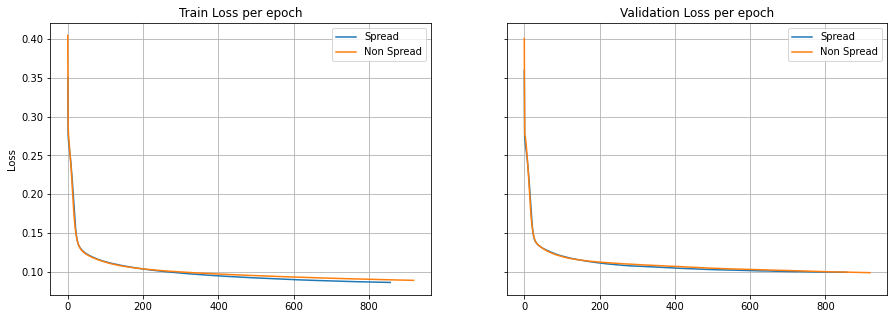

In [24]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

loss_ss_non_spread = pd.Series(trainer_non_spread.train_losses[1:])
validations_losses_ss_non_spread = pd.Series(trainer_non_spread.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
loss_ss_non_spread.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
validations_losses_ss_non_spread.plot(ax=ax[1])

ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[0].legend(['Spread', 'Non Spread'])
ax[0].grid()

ax[1].set_title('Validation Loss per epoch')
ax[1].legend(['Spread', 'Non Spread'])
ax[1].grid()

Scores

In [20]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
quantilenet_non_spread_scores = get_scores(y_pred_quantilenet_non_spread, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, quantilenet_non_spread_scores], axis=1, keys=['Spread', 'Non Spread']
)
final_scores

,Spread,Non Spread
QS,0.094302,0.094054
IS,28.967859,28.971727
Sharpnees,0.217846,0.221713
ACE,1.699489,1.673801


Plots

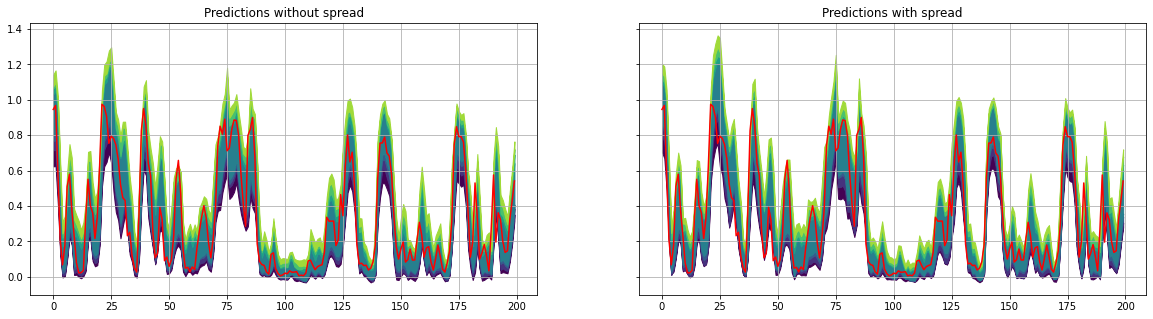

In [27]:
viridis = cm.get_cmap('viridis', len(quantiles))
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)

for i in range(len(y_preds_quantilenet_non_spread.columns)-1):
    ax[0].fill_between(
        y_preds_quantilenet_non_spread.index[:200], 
        y_preds_quantilenet_non_spread[i][:200], 
        y_preds_quantilenet_non_spread[i+1][:200], 
        color=viridis.colors[i]
    )  
y_test[:200].plot(color='red', ax=ax[0])
ax[0].set_title('Predictions without spread')
ax[0].grid()

for i in range(len(y_preds_quantilenet.columns)-1):
    ax[1].fill_between(
        y_preds_quantilenet.index[:200], 
        y_preds_quantilenet[i][:200], 
        y_preds_quantilenet[i+1][:200], 
        color=viridis.colors[i]
    )
y_test[:200].plot(color='red', ax=ax[1])
ax[1].set_title('Predictions with spread')
ax[1].grid()